# Aspect Based Sentiment Analysis

In [1]:
# Load necessary library and module
import warnings
warnings.filterwarnings('ignore')

import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import string
import unicodedata
import nltk
import sklearn
import scipy

nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#%matplotlib inline
# %load_ext google.colab.data_table

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Dataset

In [102]:
# Read and show sample data
mlbb = pd.read_csv('review_mobile-banking_2023.csv', encoding='ISO-8859-1')


In [103]:
mlbb.head()

,reviewId,userName,userImage,content,score,label,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,df52bd76-9ecb-4a58-960e-3aafc66730b3,Fadhil Rahman Dwiputro,https://play-lh.googleusercontent.com/a/AATXAJ...,"I'd rate higher but there's a problem, everyti...",1,negative,1862,1.6.72.7351,2022-05-21 3:26:47,NaN,NaN,most_relevant,com.mobile.legends
1,62b580cf-d289-427b-934c-809057f6f5c6,Leif Nambara,https://play-lh.googleusercontent.com/a/AATXAJ...,"just recently, it can't even start a game. It ...",1,negative,977,1.6.72.7351,2022-05-08 9:25:17,NaN,NaN,most_relevant,com.mobile.legends
2,00e71d39-ae15-451e-8c34-129ac57419e5,Davina Fernanda,https://play-lh.googleusercontent.com/a-/AOh14...,"The game is fun, interesting, has a lot of her...",1,negative,62,1.6.72.7351,2022-05-30 4:58:08,NaN,NaN,most_relevant,com.mobile.legends
3,7eb07db9-051a-4be9-ac67-5983b0447b11,Af Jocelin,https://play-lh.googleusercontent.com/a-/AOh14...,Its been more than 4 years im playing this gam...,1,negative,704,1.6.72.7351,2022-04-17 3:43:07,NaN,NaN,most_relevant,com.mobile.legends
4,3401476b-04f8-4fb4-b538-dc663bc0efc7,Fernando Willian Gaming,https://play-lh.googleusercontent.com/a/AATXAJ...,You know what? I don't care anymore. The devel...,1,negative,62,1.6.72.7351,2022-05-27 7:14:08,NaN,NaN,most_relevant,com.mobile.legends


In [104]:
mlbb = mlbb[['content', 'score','label']]
mlbb = mlbb.dropna()
mlbb.head()

,content,score,label
0,"I'd rate higher but there's a problem, everyti...",1,negative
1,"just recently, it can't even start a game. It ...",1,negative
2,"The game is fun, interesting, has a lot of her...",1,negative
3,Its been more than 4 years im playing this gam...,1,negative
4,You know what? I don't care anymore. The devel...,1,negative


In [109]:
mlbb.head()

,content,score,label,sentiment,polarity
0,"I'd rate higher but there's a problem, everyti...",1,negative,0,negative
1,"just recently, it can't even start a game. It ...",1,negative,0,negative
2,"The game is fun, interesting, has a lot of her...",1,negative,0,negative
3,Its been more than 4 years im playing this gam...,1,negative,0,negative
4,You know what? I don't care anymore. The devel...,1,negative,0,negative


In [110]:
# score to polarity
def to_polarity(rating):
  rating = int(rating)
  if rating <= 2:
    return 'negative'
  elif rating == 3:
    return 'neutral'
  else: 
    return 'positive'

# score to sentiment
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2


In [111]:

class_names = ['negative', 'neutral', 'positive']

mlbb['sentiment'] = mlbb.score.apply(to_sentiment)
mlbb['polarity'] = mlbb.score.apply(to_polarity)
ffm['sentiment'] = ffm.score.apply(to_sentiment)
ffm['polarity'] = ffm.score.apply(to_polarity)
hdi['sentiment'] = hdi.score.apply(to_sentiment)
hdi['polarity'] = hdi.score.apply(to_polarity)

# mlbb.head(3000)

In [112]:
mlbb['polarity'].value_counts()

negative    400
neutral     400
positive    400
Name: polarity, dtype: int64

In [113]:
#CHECKING FOR MISSING VALUES
mlbb.isnull().sum()
# ffm.isnull().sum()
# hdi.isnull().sum()

content      0
score        0
label        0
sentiment    0
polarity     0
dtype: int64

In [114]:
ffm.shape

(1200, 15)

In [36]:
mlbb.dropna(inplace=True)
mlbb.isnull().sum()
ffm.dropna(inplace=True)
ffm.isnull().sum()
hdi.dropna(inplace=True)
hdi.isnull().sum()

content      0
score        0
label        0
sentiment    0
polarity     0
dtype: int64

<AxesSubplot:xlabel='polarity', ylabel='count'>

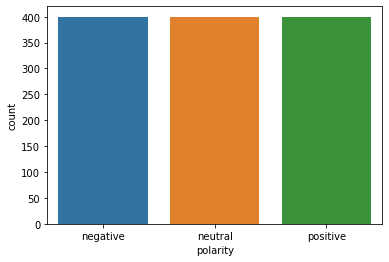

In [115]:
sns.countplot(ffm.polarity)

In [116]:
mlbb.describe()

,score,sentiment
count,1200.000000,1200.000000
mean,3.000000,1.000000
std,1.291533,0.816837
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,1.000000
75%,4.000000,2.000000
max,5.000000,2.000000


# TextBlob


In [16]:
# TextBlob
# https://www.analyticsvidhya.com/blog/2021/10/sentiment-analysis-with-textblob-and-vader/
# !pip install textblob


In [17]:
from textblob import TextBlob

In [37]:
def sentiment_calc(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None


In [38]:
def textblob_polarity(text):
    try:
        return TextBlob(text).polarity
    except:
        return None

In [39]:
def textblob_subject(text):
    try:
        return TextBlob(text).subjectivity
    except:
        return None

In [40]:

mlbb['textblob_sentiment'] = mlbb['content'].apply(sentiment_calc)
mlbb['textblob_polarity'] = mlbb['content'].apply(textblob_polarity)
mlbb['textblob_subject'] = mlbb['content'].apply(textblob_subject)

In [117]:
mlbb.head()

,content,score,label,sentiment,polarity
0,"I'd rate higher but there's a problem, everyti...",1,negative,0,negative
1,"just recently, it can't even start a game. It ...",1,negative,0,negative
2,"The game is fun, interesting, has a lot of her...",1,negative,0,negative
3,Its been more than 4 years im playing this gam...,1,negative,0,negative
4,You know what? I don't care anymore. The devel...,1,negative,0,negative


In [18]:
# sentence = mlbb.content[1100]
# print(mlbb.score[1100])
# print(sentence)
# res = TextBlob(sentence)
# print(res.sentiment.polarity)
# print(res.sentiment.subjectivity)

5
Great game overall, I do lag sometimes lime other people but there's times that I play without lagging.but sometimes there's just some toxic people that I hate, so I think if u report a toxic player they get banned for a week so they will understand not to be toxic.
-0.10500000000000001
0.485


# Vader

In [66]:
# !pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader=SentimentIntensityAnalyzer()

In [67]:

mlbb['vader_compound'] = [vader.polarity_scores(x)['compound'] for x in mlbb['content']]
mlbb['vader_neg'] = [vader.polarity_scores(x)['neg'] for x in mlbb['content']]
mlbb['vader_neu'] = [vader.polarity_scores(x)['neu'] for x in mlbb['content']]
mlbb['vader_pos'] = [vader.polarity_scores(x)['pos'] for x in mlbb['content']]

In [68]:
mlbb.head()

,content,score,label,sentiment,polarity,textblob_sentiment,textblob_polarity,textblob_subject,vader_polarity,vader_compound,vader_neg,vader_neu,vader_pos
0,"I'd rate higher but there's a problem, everyti...",1,negative,0,negative,"(0.30625, 0.625)",0.306250,0.625000,None,0.9224,0.107,0.687,0.206
1,"just recently, it can't even start a game. It ...",1,negative,0,negative,"(-0.040000000000000036, 0.49000000000000005)",-0.040000,0.490000,None,0.6728,0.044,0.845,0.111
2,"The game is fun, interesting, has a lot of her...",1,negative,0,negative,"(0.09999999999999999, 0.35000000000000003)",0.100000,0.350000,None,-0.0745,0.102,0.773,0.126
3,Its been more than 4 years im playing this gam...,1,negative,0,negative,"(0.13205128205128205, 0.511965811965812)",0.132051,0.511966,None,0.9325,0.060,0.742,0.198
4,You know what? I don't care anymore. The devel...,1,negative,0,negative,"(-0.22120181405895692, 0.33106575963718815)",-0.221202,0.331066,None,-0.5931,0.109,0.841,0.050


# Text Pre-Processing

In [118]:
# Apply text pre-processing to DataFrame
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

In [119]:
print(mlbb.content)

0       I'd rate higher but there's a problem, everyti...
1       just recently, it can't even start a game. It ...
2       The game is fun, interesting, has a lot of her...
3       Its been more than 4 years im playing this gam...
4       You know what? I don't care anymore. The devel...
                              ...                        
1195                                     she is good game
1196                                                  Idk
1197                        This game is so good ilove it
1198               Nice I hope moonton give me a skin all
1199    Laggy but so fun to play but i like a requests...
Name: content, Length: 1200, dtype: object


In [120]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [89]:
def stemmin(text):
    # try:
    words = word_tokenize(text)
    stemn = [porter_stemmer.stem(w) for w in words]
    # for w in words:
    #     stems = porter_stemmer.stem(w)
    stemm = ' '.join(stemn)
    # except:
        # return text
    return stemm

In [90]:
text = "just recently, it can't even start a game. It always crashed on hero selection screen. Than after restart, it crashes again at loading screen, always at around 20%. I have tried restarting, reloading, reinstalling the game, turning off Samsung game launcher, etc. Nothing worked. So the problem is not on the phone. It has worked wonderfully before for three years."
stemmin(text)

"just recent , it ca n't even start a game . it alway crash on hero select screen . than after restart , it crash again at load screen , alway at around 20 % . i have tri restart , reload , reinstal the game , turn off samsung game launcher , etc . noth work . so the problem is not on the phone . it ha work wonder befor for three year ."

In [121]:
mlbb.head()

,content,score,label,sentiment,polarity
0,"I'd rate higher but there's a problem, everyti...",1,negative,0,negative
1,"just recently, it can't even start a game. It ...",1,negative,0,negative
2,"The game is fun, interesting, has a lot of her...",1,negative,0,negative
3,Its been more than 4 years im playing this gam...,1,negative,0,negative
4,You know what? I don't care anymore. The devel...,1,negative,0,negative


In [122]:
def text_preprocessing(text):
  text = text.lower()                                   # Lowercase all sentences
  text = text.strip()                                   # Remove whitespace
  text = re.sub('[-+]?[0-9]+', ' ', text)               # Remove numbers 
  text = re.sub(r'https?://\S+|www\.\S+', ' ', text)    # Remove URLs
  text = re.sub(r"pic.twitter.com\S+", ' ', text)       # Remove custom URLs for twitter
  text = re.sub(r'\@([\w]+)',' ', text)                 # Remove Mention @
  text = re.sub(r'\#([\w]+)',' ', text)                 # Remove #TAGAR
  text = re.sub('\S*@\S*\s?', ' ', text)                # Remove email
  text = re.sub(r'[^\w\s]', ' ', text)                  # Remove punctuation
  text = re.sub(r'\b\w{1,3}\b','',text)                 #Remove n-chars,Remove less than 3 chars, minimum 4 character allowed "\b[a-zA-Z0-9]{3}\b"
  text = re.sub(r'[!$%^&*@#()_+|~=`{}\[\]%\-:";\'<>?,.\/]', ' ', text)  # Tahap-5: simbol
  text = re.sub(r'[0-9]+','', text)                     # Tahap-6: angka
  text = re.sub(r'([a-zA-Z])\1\1','\\1', text)          # Tahap-7: koreksi duplikasi tiga karakter beruntun atau lebih (contoh. yukkk)
  text = re.sub(' +',' ', text)                         #remove multiple whitespace
  text = re.sub(r'^[ ]|[ ]$','', text)                  # Tahap-9: spasi di awal dan akhir kalimat

  # text = re.sub('\b[a-zA-Z0-9]{3}\b','',text)
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore') # Remove non-ascii character
  word_tokens = word_tokenize(text) # Word tokenize
  
  stem_words = [porter_stemmer.stem(w) for w in word_tokens]
  
  # Define Indonesian stopwords removal
  stop_words = stopwords.words('english')  # NLTK Indonesian stopwords
  clean_words = [word for word in stem_words if word not in stop_words] # stopwords removal
  clean_words = ' '.join(clean_words)

  words = set(nltk.corpus.words.words())
  word_cleaner = word_tokenize(clean_words)
  cleaner_words = [w for w in word_cleaner if w.lower() in words or not w.isalpha()] #remove non english

  cleaner = ' '.join(cleaner_words)


#   cleaner = " ".join(w for w in nltk.wordpunct_tokenize(clean_words) \
        #   if w.lower() in words or not w.isalpha())
  return cleaner

In [130]:
pre=text_preprocessing(mlbb['content'][50])

In [131]:
print(pre)

game veri poor match skill player therefor result veri long lose streak kill play game point report poor player long player score decent system automat report player kill team goal win


In [132]:
mlbb['clean_content'] = mlbb['content'].progress_apply(lambda x: text_preprocessing(x))
#ffm['clean_content'] = ffm['content'].progress_apply(lambda x: text_preprocessing(x))
# hdi['clean_content'] = hdi['content'].progress_apply(lambda x: text_preprocessing(x))

  0%|          | 0/1200 [00:00<?, ?it/s]

In [133]:
mlbb.head()

,content,score,label,sentiment,polarity,clean_content
0,"I'd rate higher but there's a problem, everyti...",1,negative,0,negative,rate higher problem hold hero alway disappear ...
1,"just recently, it can't even start a game. It ...",1,negative,0,negative,recent even start game alway crash hero select...
2,"The game is fun, interesting, has a lot of her...",1,negative,0,negative,game interest hero recent game bug mani time s...
3,Its been more than 4 years im playing this gam...,1,negative,0,negative,year play game never went previous match hero ...
4,You know what? I don't care anymore. The devel...,1,negative,0,negative,know care develop never play around game long ...


In [93]:

# ffm.to_csv( "ffm_clean_content_after_preprocessing_21062022.csv", index=False, encoding='utf-8-sig')
# hdi.to_csv( "hdi_clean_content_after_preprocessing_21062022.csv", index=False, encoding='utf-8-sig')


In [95]:

# mlbb.dropna(inplace=True)

In [96]:
mlbb.isnull().sum()#.values()

content               0.0
score                 0.0
label                 0.0
sentiment             0.0
polarity              0.0
textblob_sentiment    0.0
textblob_polarity     0.0
textblob_subject      0.0
vader_polarity        0.0
vader_compound        0.0
vader_neg             0.0
vader_neu             0.0
vader_pos             0.0
clean_content         0.0
dtype: float64

In [134]:
mlbb.to_csv( "dataset/mlbb_clean_content_after_preprocessing_24062022.csv", index=False, encoding='utf-8-sig')
ffm.to_csv( "dataset/ffm_clean_content_after_preprocessing_21062022.csv", index=False, encoding='utf-8-sig')
hdi.to_csv( "dataset/hdi_clean_content_after_preprocessing_21062022.csv", index=False, encoding='utf-8-sig')